<a href="https://colab.research.google.com/github/RamSaw/deep-unsupervised-learning/blob/master/HW01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt

In [0]:
import numpy as np
def sample_data():
  count = 10000
  rand = np.random.RandomState(0)
  a = 0.3 + 0.1 * rand.randn(count)
  b = 0.8 + 0.05 * rand.randn(count)
  mask = rand.rand(count) < 0.5
  samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
  return np.digitize(samples, np.linspace(0.0, 1.0, 100))

def sample_data_validation():
  count = 2000
  rand = np.random.RandomState(4534)
  a = 0.3 + 0.1 * rand.randn(count)
  b = 0.8 + 0.05 * rand.randn(count)
  mask = rand.rand(count) < 0.5
  samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
  return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [155]:
X = sample_data()
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
X_val = sample_data_validation()
X_train, X_val, X_test = torch.tensor(X_train), torch.tensor(X_val), torch.tensor(X_test)
print(X_train.shape)
print(X_train[:3])
print(X_val.shape)
print(X_val[:3])
print(X_test.shape)
print(X_test[:3])

torch.Size([8000])
tensor([81, 24, 84])
torch.Size([2000])
tensor([21, 55, 90])
torch.Size([2000])
tensor([84, 18, 78])


In [0]:
class SoftMaxModel(nn.Module):
  def __init__(self, num_labels):
      super(SoftMaxModel, self).__init__()

      self.num_labels = num_labels
      self.thetas = torch.zeros(num_labels, requires_grad=True)
      self.soft = nn.LogSoftmax(dim=0)

  def forward(self):
    return self.soft(self.thetas)

  def parameters(self):
        return [self.thetas]


In [157]:
model_test = SoftMaxModel(10)
for param in model_test.parameters():
    if param.requires_grad:
        print(param.data)
print(model_test())

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([-2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026,
        -2.3026, -2.3026], grad_fn=<LogSoftmaxBackward>)


In [0]:
def train(lr, batch_size, num_epochs):
  model = SoftMaxModel(100)
  loss_function = nn.NLLLoss(reduction='mean')
  optimizer = optim.SGD(model.parameters(), lr=lr)

  trainloader = DataLoader(X_train, batch_size=batch_size)
  num_batches = len(trainloader)
  for epoch in range(num_epochs):
      for i, batch in enumerate(trainloader):
        model.zero_grad()
        probs = model()
        probs = probs.repeat(batch.size()[0], 1)
        loss = loss_function(probs, batch)
        loss.backward()
        optimizer.step()
        #if i == 0:
        #  print(f'Negative log likelihood on {i} / {num_batches} step: {float(loss)}')

  with torch.no_grad():
      probs = model()
      probs = probs.repeat(X_val.size()[0], 1)
      loss = loss_function(probs, X_val)
      print(f'Loss on validation set {float(loss)}')
      return float(loss)

In [159]:
lrs = [0.1, 0.01, 0.001]
batch_sizes = [128, 256, 512, 1024]
num_epochs = [5, 20]

best_hyperparams = None
best_loss = 1000
for num_epoch in num_epochs:
  for batch_size in batch_sizes:
    for lr in lrs:
      print(f"Hyperparameters: lr = {lr}, batch_size = {batch_size}, num_epoch = {num_epoch}")
      loss = train(lr, batch_size, num_epoch)
      if loss < best_loss:
        best_loss = loss
        best_hyperparams = (lr, batch_size, num_epoch)
print(f'Best: best_loss = {best_loss}, best_hyperparams = {best_hyperparams}')

Hyperparameters: lr = 0.1, batch_size = 128, num_epoch = 5
Loss on validation set 4.3578643798828125
Hyperparameters: lr = 0.01, batch_size = 128, num_epoch = 5
Loss on validation set 4.571216106414795
Hyperparameters: lr = 0.001, batch_size = 128, num_epoch = 5
Loss on validation set 4.601668357849121
Hyperparameters: lr = 0.1, batch_size = 256, num_epoch = 5
Loss on validation set 4.4554595947265625
Hyperparameters: lr = 0.01, batch_size = 256, num_epoch = 5
Loss on validation set 4.587661266326904
Hyperparameters: lr = 0.001, batch_size = 256, num_epoch = 5
Loss on validation set 4.603391647338867
Hyperparameters: lr = 0.1, batch_size = 512, num_epoch = 5
Loss on validation set 4.523371696472168
Hyperparameters: lr = 0.01, batch_size = 512, num_epoch = 5
Loss on validation set 4.596340656280518
Hyperparameters: lr = 0.001, batch_size = 512, num_epoch = 5
Loss on validation set 4.604288101196289
Hyperparameters: lr = 0.1, batch_size = 1024, num_epoch = 5
Loss on validation set 4.5624

In [0]:
def plot_training(lr, batch_size, num_epochs):
  model = SoftMaxModel(100)
  loss_function = nn.NLLLoss(reduction='mean')
  optimizer = optim.SGD(model.parameters(), lr=lr)

  trainloader = DataLoader(X_train, batch_size=batch_size)
  num_batches = len(trainloader)

  t = []
  loss_train = []
  loss_val = []

  fig, ax = plt.subplots()
  
  ax.set(xlabel='step', ylabel='loss',
        title='Loss behaviour')

  step = 0
  for epoch in range(num_epochs):
      for i, batch in enumerate(trainloader):
        model.zero_grad()
        probs = model()
        probs = probs.repeat(batch.size()[0], 1)
        loss = loss_function(probs, batch)
        loss.backward()
        optimizer.step()
        step += 1
        t.append(step)
        loss_train.append(np.log2(float(loss)))
        #if i == 0:
        #  print(f'Negative log likelihood on {i} / {num_batches} step: {float(loss)}')

        with torch.no_grad():
            probs = model()
            probs = probs.repeat(X_val.size()[0], 1)
            loss = loss_function(probs, X_val)
            loss_val.append(np.log2(float(loss)))
  ax.plot(t, loss_train, label="train")
  ax.plot(t, loss_val, label="validation")
  ax.legend()
  plt.show()
  return model

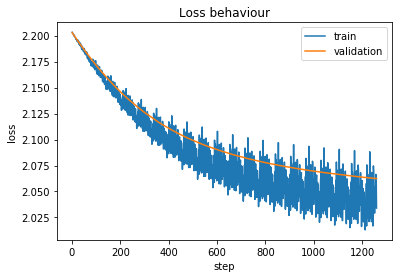

In [161]:
model = plot_training(0.1, 128, 20)

In [162]:
with torch.no_grad():
    probs = model()
    probs = probs.repeat(X_test.size()[0], 1)
    loss = loss_function(probs, X_test)
    print(f'log2(Negative log likelihood) on test: {np.log2(float(loss))}')

log2(Negative log likelihood) on test: 2.053082360200023


In [0]:
def plot_probabilities_bar(p, title):
  fig, ax = plt.subplots()
  
  ax.set(xlabel='x', ylabel='p',
        title=title)
  p.resize(100)
  ax.bar(np.arange(100), p)
  plt.show()

In [0]:
def X_to_empirical_probs(X):
  probs = np.zeros(100)
  unique, counts = np.unique(X, return_counts=True)
  probs[unique] += counts
  probs /= len(X)
  return probs

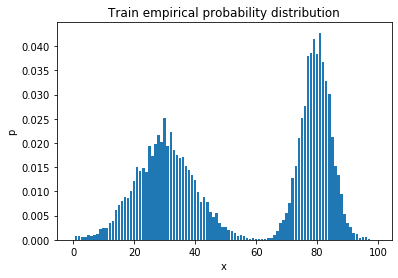

In [165]:
plot_probabilities_bar(X_to_empirical_probs(X), title='Train empirical probability distribution')

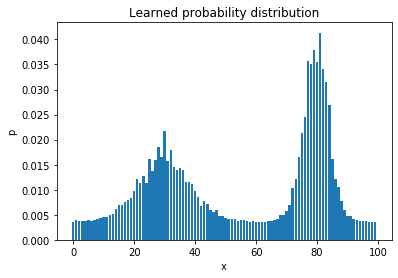

In [166]:
plot_probabilities_bar(np.exp(model().detach().numpy()), title='Learned probability distribution')

In [0]:
def sample_from_model(model, n):
  probs = np.exp(model().detach().numpy())
  probs.resize(100)
  return np.random.choice(100, n, p=probs)

In [168]:
sample_from_model(model, 10)

array([25, 82, 22,  4, 26, 75, 94, 85, 39, 25])

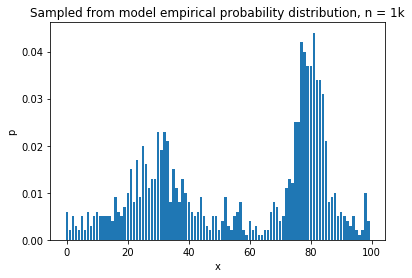

In [169]:
plot_probabilities_bar(X_to_empirical_probs(sample_from_model(model, 1000)), title='Sampled from model empirical probability distribution, n = 1k')

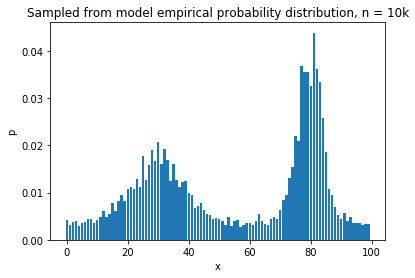

In [170]:
plot_probabilities_bar(X_to_empirical_probs(sample_from_model(model, 10000)), title='Sampled from model empirical probability distribution, n = 10k')

#Analysis
As we can see, model probability distribution is fit quite well comparing with empirical distribution calculated on train. When we do sampling from model with 1K samples it is not enough because training set is 10K in size. But we still see convergence and if we sample 10K we see pretty good convergence. Also it is noticable that the most challenging for model is to remember distribution where it has low mass. It is consistent with the theory because low probability needs more samples to converge to it.